In [1]:
import pickle
import shap
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

In [2]:
model_path = "../outputs/random_forest_high_poverty.pkl"
model = joblib.load(model_path)

In [3]:
train_path = "../outputs/train_df.csv"
test_path = "../outputs/test_df.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [4]:
X_train = train_df.drop(columns=["fully_funded", "date_posted"])
y_train = train_df["fully_funded"]

X_test = test_df.drop(columns=["fully_funded", "date_posted"])
y_test = test_df["fully_funded"]

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((389743, 132), (114037, 133), (389743,), (114037,))

In [6]:
set(X_train.columns) - set(X_test.columns)
set(X_test.columns) - set(X_train.columns)
X_test = X_test[X_train.columns]

In [7]:
X_train.shape, X_test.shape

((389743, 132), (114037, 132))

In [8]:
expected_features = model.feature_names_in_
extra_features = set(X_train.columns) - set(expected_features)
print("Extra features:", extra_features)

Extra features: {'poverty_level_high poverty', 'poverty_level_low poverty'}


In [9]:
X_train = X_train[expected_features]
X_test = X_test[expected_features]

In [10]:
X_train.shape, X_test.shape

((389743, 130), (114037, 130))

In [11]:
background = shap.sample(X_train, 100)
explainer = shap.KernelExplainer(model.predict_proba, background)
X_test_sample = X_test.sample(n=20, random_state=2024) 
shap_values = explainer.shap_values(X_test_sample)

  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
shap_values[0], shap_values[1]

(array([[-0.01658118, -0.00374212,  0.        , ..., -0.00431619,
         -0.00436794, -0.37427605],
        [-0.02470753, -0.00231798,  0.02252154, ...,  0.        ,
         -0.00735938,  0.01602566],
        [-0.02403705,  0.0045395 , -0.02568123, ...,  0.        ,
         -0.00347704, -0.33313963],
        ...,
        [-0.0291476 , -0.00347552,  0.02836316, ...,  0.0024347 ,
          0.00181696,  0.01503815],
        [-0.04086503,  0.02152544, -0.03297099, ...,  0.        ,
         -0.00263921,  0.00654337],
        [-0.01797537,  0.00737735, -0.02371116, ...,  0.        ,
          0.        , -0.29827616]]),
 array([[ 0.01658118,  0.00374212,  0.        , ...,  0.00431619,
          0.00436794,  0.37427605],
        [ 0.02470753,  0.00231798, -0.02252154, ...,  0.        ,
          0.00735938, -0.01602566],
        [ 0.02403705, -0.0045395 ,  0.02568123, ...,  0.        ,
          0.00347704,  0.33313963],
        ...,
        [ 0.0291476 ,  0.00347552, -0.02836316, ..., -

In [13]:
model.classes_

array([0., 1.])

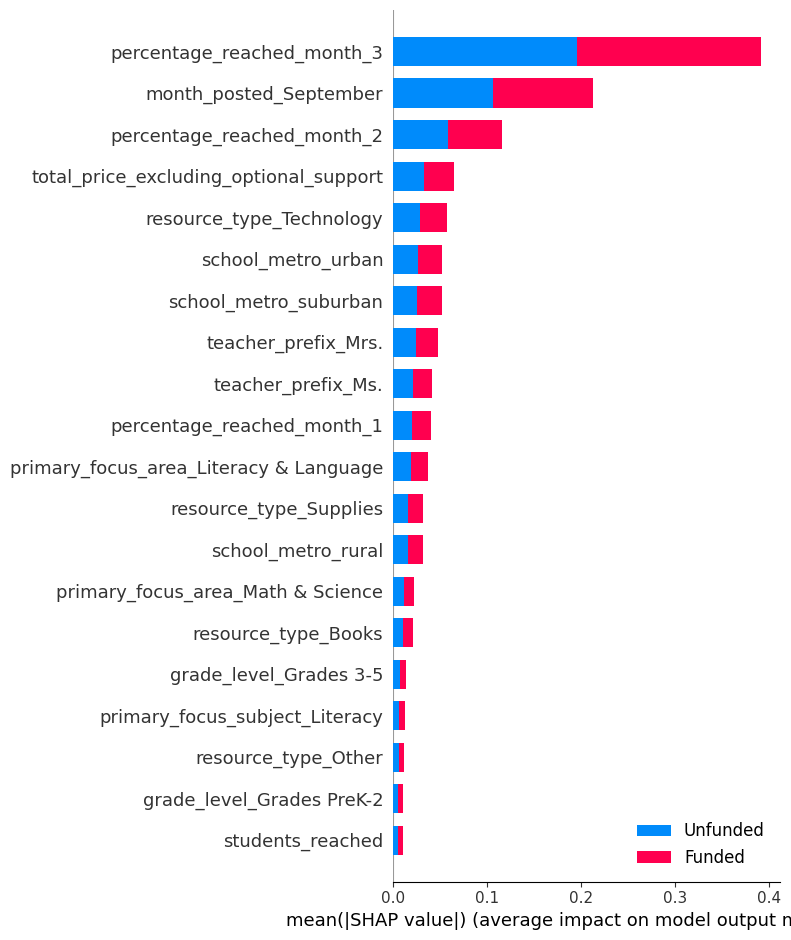

<Figure size 640x480 with 0 Axes>

In [14]:
class_names = ["Unfunded", "Funded"]
shap.summary_plot(shap_values, X_test_sample, class_names=class_names)
plt.savefig("../outputs/summary_plot_lr_high.png", bbox_inches="tight")

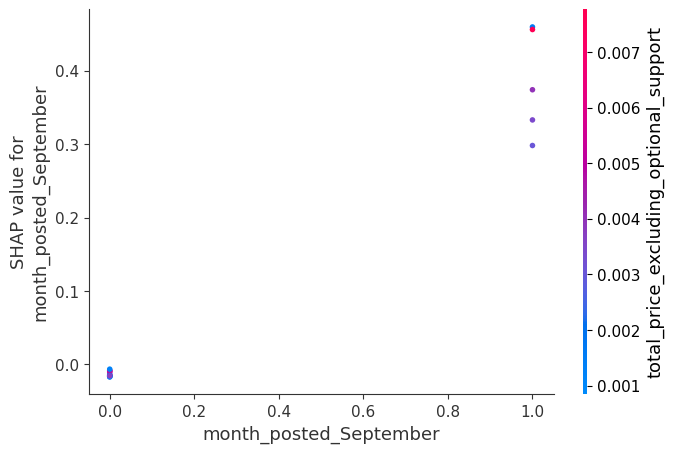

In [15]:
shap.dependence_plot("month_posted_September", shap_values[1], X_test_sample)

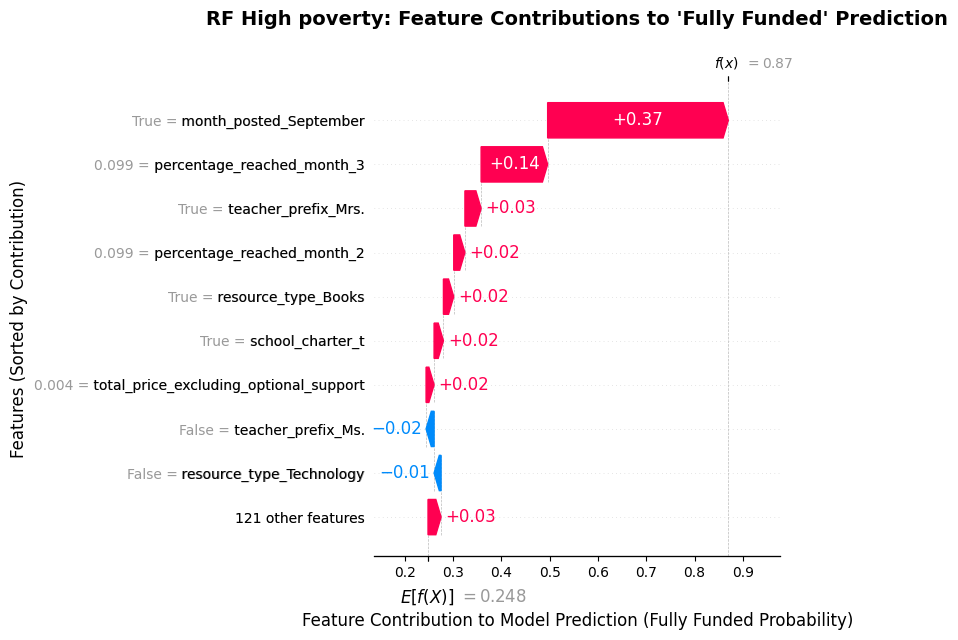

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title(
    "RF High poverty: Feature Contributions to 'Fully Funded' Prediction\n",
    fontsize=14, fontweight="bold"
)

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[1][0, :], 
        base_values=explainer.expected_value[1],  
        data=X_test_sample.iloc[0, :],
        feature_names=X_test_sample.columns 
    ),
    show=False
)

ax.set_xlabel("Feature Contribution to Model Prediction (Fully Funded Probability)", fontsize=12, labelpad=23)
ax.set_ylabel("Features (Sorted by Contribution)", fontsize=12)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.xticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()
